In [1]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import numpy as np

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
    ]) # normalize mean value: 0.5, standard deviation: 0.5
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) # divide to smaller batches because training 60000 images at once is too big to process
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [44]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # print(image.shape)
  image = image.transpose(1, 2, 0) # 28, 28, 1
  # print(image.shape)
  # print('-------------original----------------')
  # print(image)
  # print('--------------change---------------')
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denormalize to show image, normalization is consist of subtract mean and divding by the standard deviation
                                                                        # to denormalize, multiply by standard deviation and add the mean
  # print(image)
  # print('----------------end-------------')
  image = image.clip(0, 1) # restric min and max values
  return image

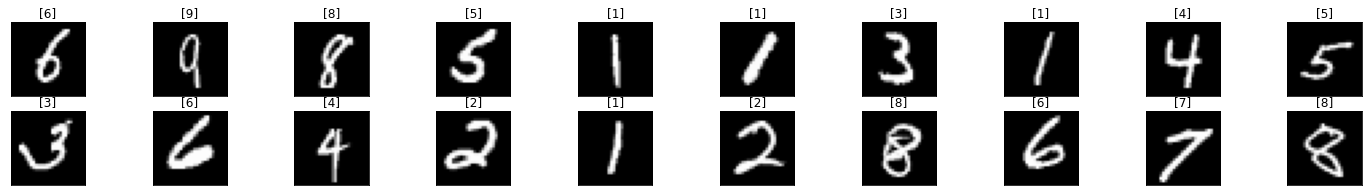

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 3))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])


In [17]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5) # input: 1, depth: 20, kernel size: 5, stride length: 1
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) # extract max feature of 2x2 size kernel
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50) # -1 option of view function automatically calculate the remaining dimention
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [18]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [20]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    
  else: # else section will be called after for loop
    with torch.no_grad(): # set all the grad flags to be false. It meams this block of codes doesn't affect grad.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch: ', e+1)
    print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch:  1
training loss: 0.5960, acc: 83.7583
validation loss: 0.1958, acc: 94.2700
epoch:  2
training loss: 0.1605, acc: 95.2850
validation loss: 0.1147, acc: 96.6900
epoch:  3
training loss: 0.1066, acc: 96.8733
validation loss: 0.0803, acc: 97.5400
epoch:  4
training loss: 0.0836, acc: 97.4967
validation loss: 0.0671, acc: 97.9000
epoch:  5
training loss: 0.0688, acc: 97.9750
validation loss: 0.0590, acc: 98.0900
epoch:  6
training loss: 0.0606, acc: 98.1000
validation loss: 0.0497, acc: 98.4800
epoch:  7
training loss: 0.0528, acc: 98.3933
validation loss: 0.0446, acc: 98.7200
epoch:  8
training loss: 0.0476, acc: 98.6117
validation loss: 0.0411, acc: 98.6900
epoch:  9
training loss: 0.0424, acc: 98.7383
validation loss: 0.0434, acc: 98.5700
epoch:  10
training loss: 0.0388, acc: 98.7967
validation loss: 0.0373, acc: 98.9000
epoch:  11
training loss: 0.0356, acc: 98.9617
validation loss: 0.0394, acc: 98.7300
epoch:  12
training loss: 0.0327, acc: 98.9900
validation loss: 0.0350, ac

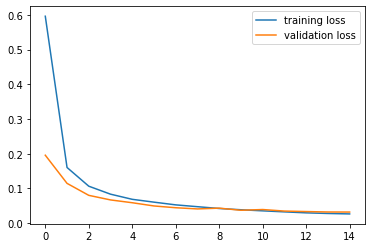

In [21]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


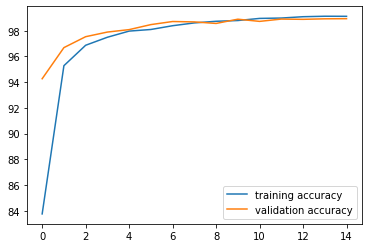

In [29]:
running_corrects_history = torch.tensor(running_corrects_history, device = 'cpu')
val_running_corrects_history = torch.tensor(val_running_corrects_history, device = 'cpu')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [35]:
!pip3 install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 2.6 MB/s 
     |████████████████████████████████| 112 kB 48.8 MB/s 
  Created wheel for pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007362 sha256=212ccb07d632dcda6f840b28b9ac2cbd05e015245cf3cf441d6741a513d34853
  Stored in directory: /root/.cache/pip/wheels/ec/1e/24/dbc5e4964ea99cad93230a9013d934fb5adc322c3102f69e45
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35432 sha256=93e02fb9e3aadbaa86bb5b29eabe1d8668e0642382b758e8cff924664419a56d
  Stored in directory: /root/.cache/pip/wheels/84/53/e6/37d90ccb3ad1a3ca98d2b17107e9fda401a7c541ea1eb6a65a
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into accou

<Response [200]>


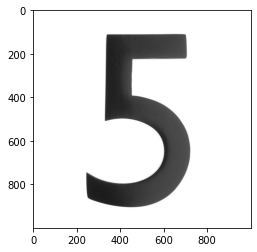

In [36]:
import PIL.ImageOps
import requests
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)

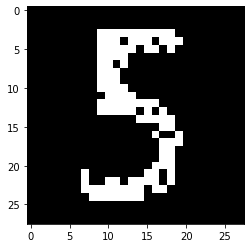

In [37]:
img = PIL.ImageOps.invert(img) # black background and white number
img = img.convert('1') # rgb to gray scale
img = transform(img) # resize and normalize
plt.imshow(im_convert(img))

In [43]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


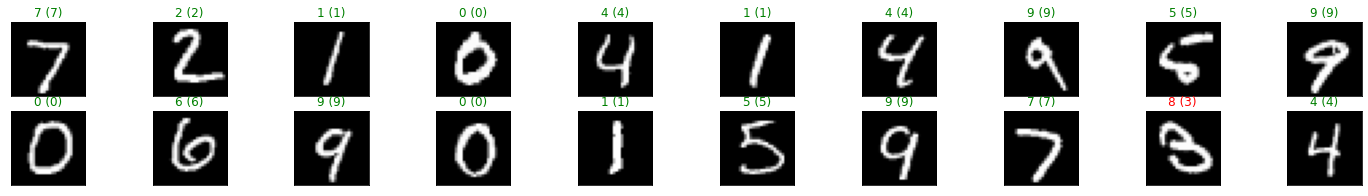

In [46]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 3))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx] == labels[idx] else 'red'))